<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "4D"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/4D/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


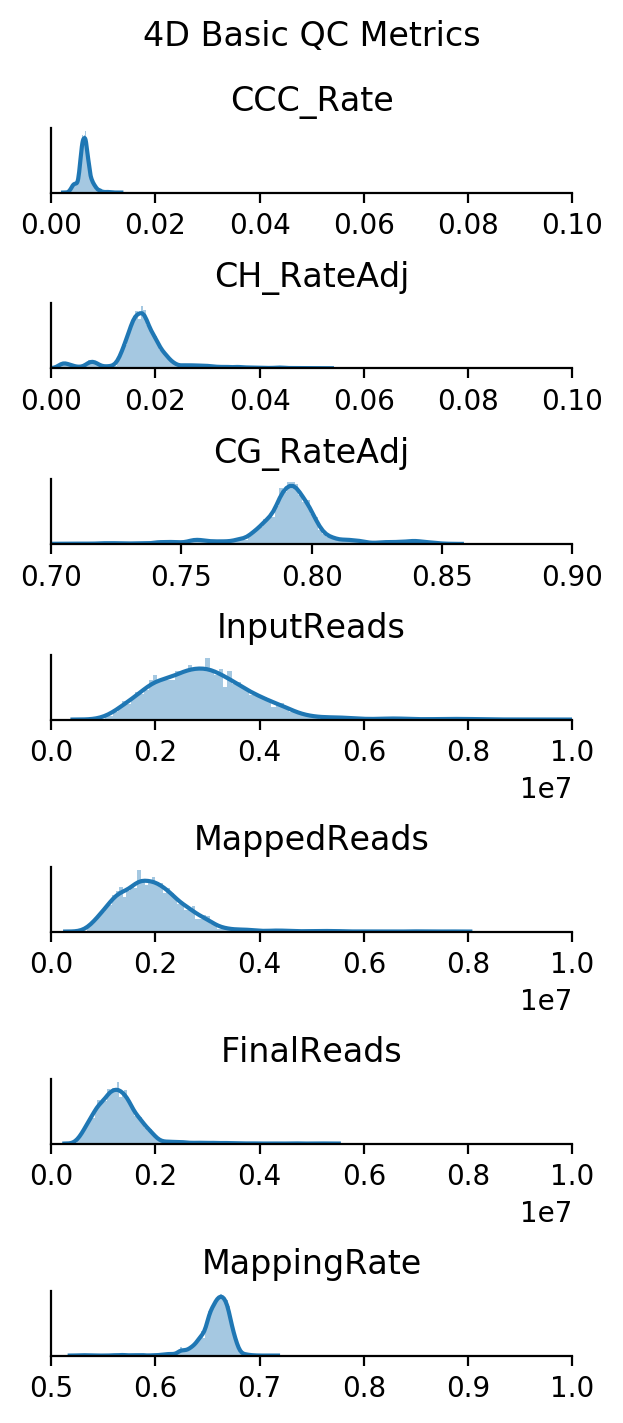

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

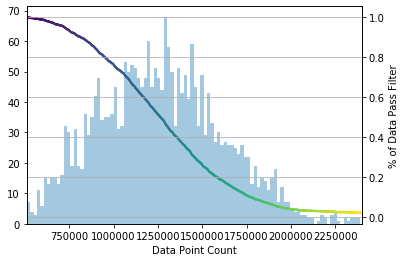

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2513/2513 (100.0%)
CG_RateAdj passed 2513/2513 (100.0%)
CH_RateAdj passed 2513/2513 (100.0%)
FinalReads passed 2513/2513 (100.0%)
MappingRate passed 2513/2513 (100.0%)
Overall passed 2513/2513 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171214 1091
171219 1422


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 315 82.0%
ad002 320 83.3%
ad004 311 81.0%
ad006 316 82.3%
ad007 312 81.2%
ad008 311 81.0%
ad010 313 81.5%
ad012 315 82.0%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
4D_M_0,/gale/raidix/rdx-4/CEMBA_RS1/4D/CEMBA171214_4D...,0.00694,0.81134,0.81002,0.02342,0.01660,657764.0,1741014,986615.0,4D,...,7.311711,-8.820824,22.409074,39.179141,MSN-D2 Col14a1,1.701002,0.170927,10.837798,2.497455,True
4D_M_1,/gale/raidix/rdx-4/CEMBA_RS1/4D/CEMBA171214_4D...,0.00542,0.76056,0.75926,0.01351,0.00813,1500716.0,3586628,2397415.0,4D,...,-3.222288,-9.217075,1.707908,15.438893,ODC odc-large,-4.250328,6.282861,-4.086282,26.767815,True
4D_M_10,/gale/raidix/rdx-4/CEMBA_RS1/4D/CEMBA171214_4D...,0.00697,0.79077,0.78930,0.02308,0.01622,1319156.0,2996868,1985692.0,4D,...,9.796597,-7.801700,38.669220,30.388533,MSN-D2 Slc24a2,-3.754697,0.273665,-16.633013,13.841065,True
4D_M_100,/gale/raidix/rdx-4/CEMBA_RS1/4D/CEMBA171219_4D...,0.00451,0.77869,0.77769,0.01632,0.01186,1231575.0,2835048,1835427.0,4D,...,-3.549768,10.831806,-3.500754,-62.830505,OLF-Exc Unc13c,-1.802696,-10.222608,19.944326,0.303172,True
4D_M_1001,/gale/raidix/rdx-4/CEMBA_RS1/4D/CEMBA171214_4D...,0.00615,0.79116,0.78987,0.02420,0.01816,1394131.0,3172280,2092469.0,4D,...,-2.180739,-21.357641,53.975185,-2.811461,MSN-D1 Hrh1,-3.812401,4.304296,-15.192435,8.046325,True
4D_M_1002,/gale/raidix/rdx-4/CEMBA_RS1/4D/CEMBA171214_4D...,0.00714,0.78808,0.78656,0.02800,0.02101,1788123.0,4144348,2746673.0,4D,...,-3.025823,-23.346880,65.452627,-8.650497,MSN-D1 Hrh1,-7.251977,8.640623,-26.634364,-19.460813,True
4D_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/4D/CEMBA171214_4D...,0.00649,0.78350,0.78209,0.02397,0.01759,967089.0,2154422,1397260.0,4D,...,-2.311469,-21.609325,52.286187,-2.464549,MSN-D1 Hrh1,-4.947893,5.542718,-15.266838,1.515157,True
4D_M_1004,/gale/raidix/rdx-4/CEMBA_RS1/4D/CEMBA171214_4D...,0.00640,0.78291,0.78151,0.02378,0.01749,1919986.0,4517632,3034108.0,4D,...,11.310469,-9.211360,45.876321,35.078539,MSN-D2 Slc24a2,-5.227255,3.565995,-8.493515,28.499565,True
4D_M_1005,/gale/raidix/rdx-4/CEMBA_RS1/4D/CEMBA171214_4D...,0.00649,0.78865,0.78727,0.02346,0.01708,1055611.0,2411420,1576274.0,4D,...,-5.448304,-19.444817,38.671249,-19.172301,MSN-D1 Khdrbs3,-11.014170,4.346200,17.644281,-9.625682,True
4D_M_1006,/gale/raidix/rdx-4/CEMBA_RS1/4D/CEMBA171219_4D...,0.00616,0.79206,0.79077,0.02208,0.01602,1230393.0,2839362,1859023.0,4D,...,7.478210,-9.972087,22.668775,44.387344,MSN-D2 Col14a1,2.090100,2.534276,19.646757,6.797631,True
